In [1]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
col = ['au1', 'au12', 'au15', 'au17', 'au2', 'au20', 'au25', 'au26', 'au4', 'au5', 'au6', 'au9']

fb_feat=np.load('/kaggle/input/vit-features/google_vit_feat.npy')
print(fb_feat.shape)

(112198, 768)


In [3]:
df=pd.read_csv('/kaggle/input/clahe-labels/labels_path.csv')
labels=df.drop(columns=['paths'])
from collections import Counter
for i in labels.columns:
    print(i,Counter(labels[i]))

au1 Counter({0: 103420, 3: 2809, 1: 2272, 2: 1749, 4: 1393, 5: 555})
au12 Counter({0: 81404, 1: 13943, 3: 7233, 2: 6869, 4: 2577, 5: 172})
au15 Counter({0: 104336, 1: 5180, 2: 1618, 3: 1017, 4: 47})
au17 Counter({0: 99268, 1: 6342, 2: 4184, 3: 2281, 4: 112, 5: 11})
au2 Counter({0: 104834, 3: 3505, 1: 1720, 2: 934, 4: 836, 5: 369})
au20 Counter({0: 107666, 2: 1608, 1: 1591, 3: 1305, 4: 28})
au25 Counter({0: 66146, 3: 15693, 2: 13935, 1: 9805, 4: 5580, 5: 1039})
au26 Counter({0: 87222, 1: 13443, 2: 7473, 3: 3529, 4: 314, 5: 217})
au4 Counter({0: 87604, 2: 7636, 3: 6586, 1: 4661, 4: 4328, 5: 1383})
au5 Counter({0: 109469, 1: 1579, 2: 719, 3: 293, 4: 104, 5: 34})
au6 Counter({0: 92714, 1: 9157, 2: 5986, 3: 3599, 4: 601, 5: 141})
au9 Counter({0: 105066, 3: 3045, 2: 2035, 1: 1659, 4: 316, 5: 77})


In [4]:
df

,au1,au12,au15,au17,au2,au20,au25,au26,au4,au5,au6,au9,paths
0,0,2,0,0,0,0,0,0,0,0,0,0,frames\RightVideoSN001\0.jpg
1,0,2,0,0,0,0,0,0,0,0,0,0,frames\RightVideoSN001\1.jpg
2,0,2,0,0,0,0,0,0,0,0,0,0,frames\RightVideoSN001\2.jpg
3,0,2,0,0,0,0,0,0,0,0,0,0,frames\RightVideoSN001\3.jpg
4,0,2,0,0,0,0,0,0,0,0,0,0,frames\RightVideoSN001\4.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112193,0,0,0,0,0,0,3,0,5,0,3,5,frames\RightVideoSN032\4840.jpg
112194,0,0,0,0,0,0,3,0,5,0,3,5,frames\RightVideoSN032\4841.jpg
112195,0,0,0,0,0,0,3,0,5,0,3,5,frames\RightVideoSN032\4842.jpg
112196,0,0,0,0,0,0,3,0,5,0,3,5,frames\RightVideoSN032\4843.jpg


In [5]:
labels[labels>1]=1
labels.shape

(112198, 12)

In [6]:
112198-93375

18823

In [7]:
# Set indices for slicing
train_size = 83375
val_size = 18823
test_size = 10000

# Split the data based on indices
X_train_ur, X_val_ur, X_test_ur = fb_feat[:train_size], fb_feat[train_size:train_size+val_size], fb_feat[train_size+val_size:train_size+val_size+test_size]
y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:train_size+val_size+test_size]

print(X_train_ur.shape, X_val_ur.shape, X_test_ur.shape, y_train.shape, y_val.shape, y_test.shape)


(83375, 768) (18823, 768) (10000, 768) (83375, 12) (18823, 12) (10000, 12)


In [8]:
from sklearn.decomposition import PCA
import numpy as np
# Initialize PCA with 30 components
pca = PCA(n_components=30)

# Fit the PCA model on the data and apply dimensionality reduction
X_train = pca.fit_transform(X_train_ur)
X_val=pca.transform(X_val_ur)
X_test=pca.transform(X_test_ur)
print(X_train.shape,X_val.shape,X_test.shape)

(83375, 30) (18823, 30) (10000, 30)


In [9]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [10]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import cupy as cp
from sklearn.metrics import make_scorer, f1_score
import time 
st=time.time()

# Define the parameter grid
param_grid = {
    'estimator__n_estimators': [100, 200],  # Reduced range for n_estimators
    'estimator__max_depth': [6, 9],  # Reduced depth values
    'estimator__learning_rate': [0.01, 0.2],  # Keep learning rates
    'estimator__subsample': [0.9, 1.0],  # Subsample options
    'estimator__colsample_bytree': [0.9, 1.0],  # Column sample options
}


# Create XGBoost classifier with GPU support
xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda'
)

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# Set up GridSearchCV

# Define the scoring metric as F1 score
scoring_metric = make_scorer(f1_score, average='macro')  # Use 'macro', 'micro', or 'weighted' based on your needs

grid_search = GridSearchCV(
    estimator=multilabel_model,
    param_grid=param_grid,
    cv=2,  # Number of folds in cross-validation
    scoring='accuracy',  # You can use other metrics depending on your problem
    verbose=2,  # Increase to see more details
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(cp.array(X_train), y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on test data
print(f"Best parameters: {best_params}")
print('Accuracy on val data: {:.1f}%'.format(accuracy_score(y_val, best_model.predict(X_val))*100))
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, best_model.predict(X_test))*100))
print("time taken : ",time.time()-st)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters: {'estimator__colsample_bytree': 0.9, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 9, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Accuracy on val data: 21.2%


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:23:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy on test data: 19.9%
time taken :  630.6617879867554


In [11]:
# 4-92sec
# 8-210sec

In [12]:
col=['AU1',
 'AU12',
 'AU15',
 'AU17',
 'AU2',
 'AU20',
 'AU25',
 'AU26',
 'AU4',
 'AU5',
 'AU6',
 'AU9']

In [13]:
preds=best_model.predict(X_test)
preds.shape

(10000, 12)

METRICS FOR EACH ACTION UNIT :
AU1: ACCURACY = 0.89, F1 SCORE = 0.00
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.89      1.00      0.94      8932
           1       0.22      0.00      0.00      1068

    accuracy                           0.89     10000
   macro avg       0.56      0.50      0.47     10000
weighted avg       0.82      0.89      0.84     10000

AU12: ACCURACY = 0.84, F1 SCORE = 0.74
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.92      0.86      0.89      7182
           1       0.69      0.80      0.74      2818

    accuracy                           0.84     10000
   macro avg       0.80      0.83      0.81     10000
weighted avg       0.85      0.84      0.84     10000

AU15: ACCURACY = 0.99, F1 SCORE = 0.00
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.99      1.00      0.99      9869
           1   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

AU25: ACCURACY = 0.74, F1 SCORE = 0.80
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.78      0.56      0.65      4238
           1       0.73      0.88      0.80      5762

    accuracy                           0.74     10000
   macro avg       0.75      0.72      0.72     10000
weighted avg       0.75      0.74      0.74     10000

AU26: ACCURACY = 0.46, F1 SCORE = 0.05
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.46      0.99      0.63      4567
           1       0.72      0.02      0.05      5433

    accuracy                           0.46     10000
   macro avg       0.59      0.51      0.34     10000
weighted avg       0.60      0.46      0.31     10000

AU4: ACCURACY = 0.84, F1 SCORE = 0.00
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.84      1.00      0.91      8409
           1       0.20      0.00      0.00   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

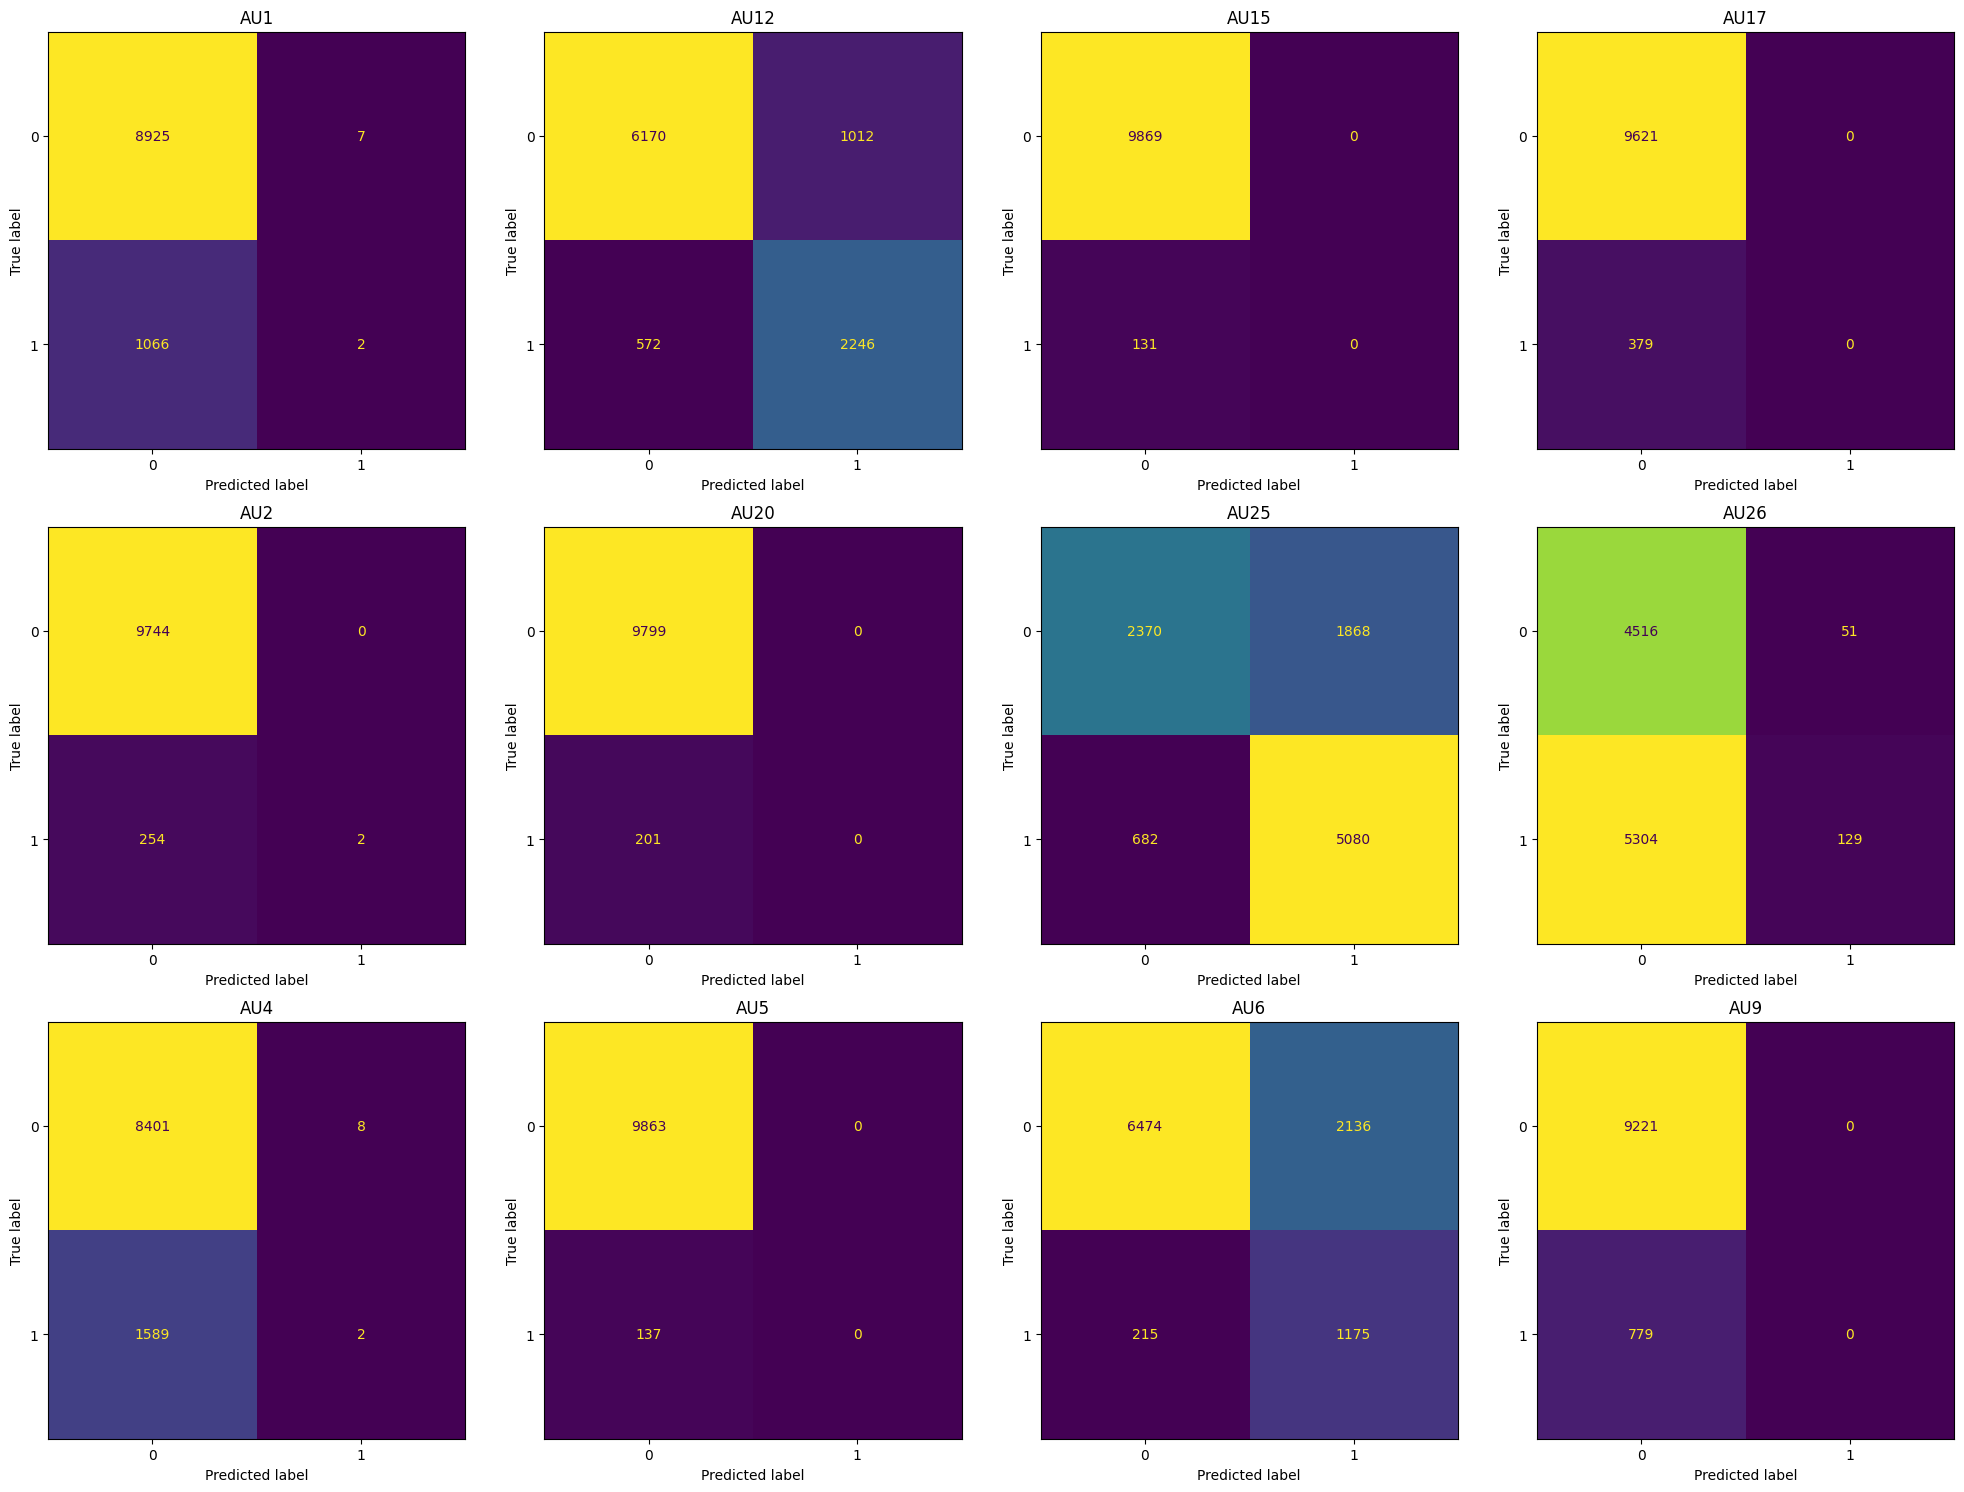

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score,classification_report

# Define action units and predictions
au = col
p = preds
test_labels = np.array(y_test)

# Create a subplot for confusion matrices
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

print("METRICS FOR EACH ACTION UNIT :")

for i in range(12):
    # Calculate accuracy
    accuracy = accuracy_score(test_labels[:, i], p[:, i])
    # Calculate F1 score
    f1 = f1_score(test_labels[:, i], p[:, i])
    
    print(f'{au[i]}: ACCURACY = {accuracy:.2f}, F1 SCORE = {f1:.2f}')
    print('CLASSIFICATION REPORT : ',classification_report(test_labels[:, i], p[:, i]))
    # Plot confusion matrix
    cm = confusion_matrix(test_labels[:, i], p[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
import joblib

# Save the trained MultiOutputClassifier model
joblib.dump(best_model, 'xgb_multilabel_model.pkl')

['xgb_multilabel_model.pkl']